In [1]:
"""
Code to train batches of cropped images using 3D U-net.

Images are expected to be 128x128x128x3 npy data (3 corresponds to the 3 channels for 
                                                  test_image_flair, test_image_t1ce, test_image_t2)
Change the U-net input shape based on your input dataset shape (e.g. if you decide to only se 2 channels or all 4 channels)

Masks are expected to be 128x128x128x3 npy data (4 corresponds to the 4 classes / labels)

"""


'\nCode to train batches of cropped images using 3D U-net.\n\nImages are expected to be 128x128x128x3 npy data (3 corresponds to the 3 channels for \n                                                  test_image_flair, test_image_t1ce, test_image_t2)\nChange the U-net input shape based on your input dataset shape (e.g. if you decide to only se 2 channels or all 4 channels)\n\nMasks are expected to be 128x128x128x3 npy data (4 corresponds to the 4 classes / labels)\n\n'

In [6]:
# !rm -r gt_data
!mv 

In [2]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
import keras.backend as K

kernel_initializer =  'he_uniform' #Try others if you want

import os
import keras
import numpy as np
# from custom_datagen import imageLoader

from matplotlib import pyplot as plt
import glob
import random
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
import datetime
# import segmentation_models_3D as sm


2024-01-18 01:57:56.194965: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 01:57:56.195023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 01:57:56.196511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 01:57:56.205496: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 01:57:57.327491: W tensorflow/compiler/tf2

In [3]:
# Set GPU device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate memory on the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


2024-01-18 01:57:59.060221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7815 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:21:00.0, compute capability: 7.5


In [4]:
tf.sysconfig.get_build_info() 

OrderedDict([('cpu_compiler', '/usr/lib/llvm-17/bin/clang'),
             ('cuda_compute_capabilities',
              ['sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '12.2'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])

In [5]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model


In [6]:
#Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 4, 4)
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 4)
(None, 128, 128, 128, 4)


In [7]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

In [8]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size


In [9]:
train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

img_list = sorted(os.listdir(train_img_dir))
msk_list = sorted(os.listdir(train_mask_dir))

num_images = len(os.listdir(train_img_dir))

In [10]:
img_list[0], msk_list[0]

('image_00002.npy', 'mask_00002.npy')

In [11]:
# verify matching idx of images and masks
img_num = random.randint(0,len(msk_list)-1)

assert(len(img_list) == len(msk_list))

for i in range(len(msk_list)-1):
    assert(img_list[i].split('_')[1] == msk_list[i].split('_')[1])

In [12]:
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

img_num

290

slice nr. 63


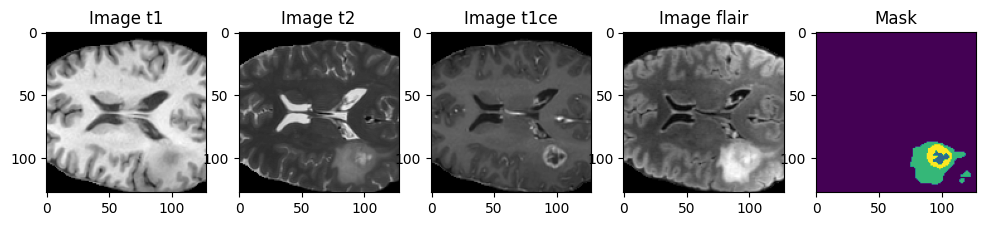

In [13]:
n_slice=random.randint(0, test_mask.shape[2])
print("slice nr.", n_slice)

plt.figure(figsize=(12, 8))

plt.subplot(151)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image t1')

plt.subplot(152)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t2')

plt.subplot(153)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t1ce')

plt.subplot(154)
plt.imshow(test_img[:,:,n_slice, 3], cmap='gray')
plt.title('Image flair')

plt.subplot(155)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [15]:
img_num

407

In [16]:
#############################################################
#Optional step of finding the distribution of each class and calculating appropriate weights
#Alternatively you can just assign equal weights and see how well the model performs: 0.25, 0.25, 0.25, 0.25
"""
import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    
    # df = df.append(conts_dict, ignore_index=True)
    df = pd.concat([df, pd.DataFrame([conts_dict])], ignore_index=True)
"""

"\nimport pandas as pd\ncolumns = ['0','1', '2', '3']\ndf = pd.DataFrame(columns=columns)\ntrain_mask_list = sorted(glob.glob('BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))\nfor img in range(len(train_mask_list)):\n    print(img)\n    temp_image=np.load(train_mask_list[img])\n    temp_image = np.argmax(temp_image, axis=3)\n    val, counts = np.unique(temp_image, return_counts=True)\n    zipped = zip(columns, counts)\n    conts_dict = dict(zipped)\n    \n    # df = df.append(conts_dict, ignore_index=True)\n    df = pd.concat([df, pd.DataFrame([conts_dict])], ignore_index=True)\n"

In [17]:
"""
label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

wt0, wt1, wt2, wt3
"""

"\nlabel_0 = df['0'].sum()\nlabel_1 = df['1'].sum()\nlabel_2 = df['1'].sum()\nlabel_3 = df['3'].sum()\ntotal_labels = label_0 + label_1 + label_2 + label_3\nn_classes = 4\n#Class weights claculation: n_samples / (n_classes * n_samples_for_class)\nwt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals\nwt1 = round((total_labels/(n_classes*label_1)), 2)\nwt2 = round((total_labels/(n_classes*label_2)), 2)\nwt3 = round((total_labels/(n_classes*label_3)), 2)\n\nwt0, wt1, wt2, wt3\n"

In [18]:
# Weights are: (0.26, 36.42, 36.42, 22.76)
wt0, wt1, wt2, wt3 = 0.26, 36.42, 36.42, 22.76
# These weihts can be used for Dice loss 

In [19]:
##############################################################
#Define the image generators for training and validation

train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

val_mask_list[0],val_mask_list[0], train_img_list[0], train_mask_list[0]
##################################

('mask_00000.npy', 'mask_00000.npy', 'image_00002.npy', 'mask_00002.npy')

In [20]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [21]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()
img.shape, msk.shape

((2, 128, 128, 128, 4), (2, 128, 128, 128, 4))

In [14]:
# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 128, 128, 128, 16)    1744      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 128, 16)    0         ['conv3d[0][0]']              
                                                                                                  
 conv3d_1 (Conv3D)           (None, 128, 128, 128, 16)    6928      ['dropout[0][0]']             
                                                                                              

1
6


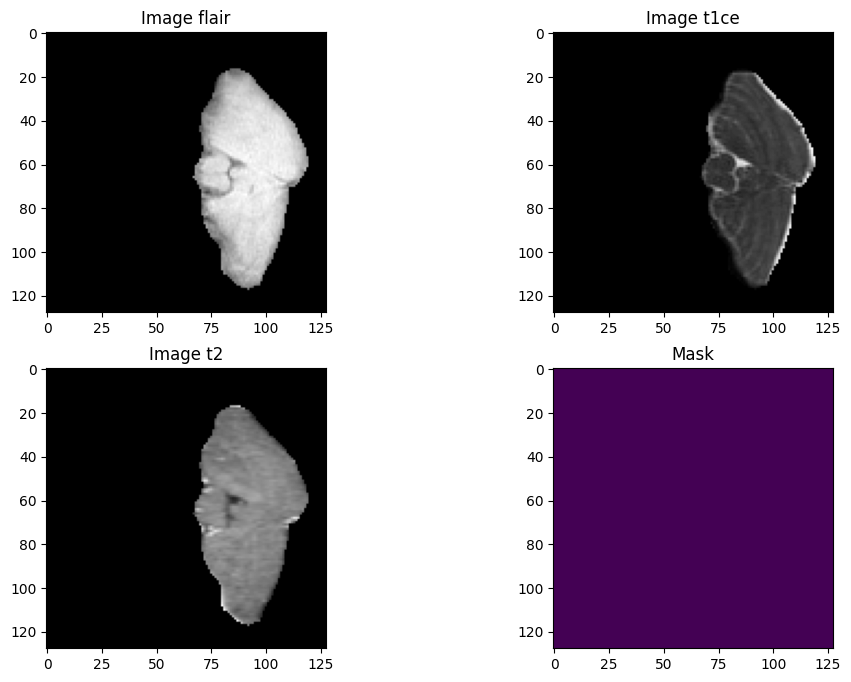

In [22]:
img_num = random.randint(0,img.shape[0]-1)
print(img_num)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
print(n_slice)
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [23]:

"""Compute metric between the predicted segmentation and the ground truth
"""

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss


# ===============================================================
# ===============================================================
# ===============================================================

# define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

# ===============================================================
# ===============================================================
# ===============================================================

def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# ===============================================================
# ===============================================================
# ===============================================================

In [15]:
###########################################################################
#Define loss, metrics and optimizer to be used for training

# wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

NameError: name 'sm' is not defined

In [16]:
metrics = ['accuracy',
           tf.keras.metrics.MeanIoU(num_classes=4),
           keras.metrics.Precision(),
           keras.metrics.Recall(),
           keras.metrics.SpecificityAtSensitivity(0.5),
           keras.metrics.SensitivityAtSpecificity(0.5),
           dice_coef, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing]

NameError: name 'dice_coef' is not defined

In [17]:
LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [18]:
#######################################################################
#Fit the model 
model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=4, 
                          num_classes=4)

In [19]:
# model.compile(optimizer = optim,
#               loss=total_loss,
#               metrics=metrics)

model.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics = metrics)

NameError: name 'metrics' is not defined

In [20]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 128, 4)]   0         []                            
                                                                                                  
 conv3d_19 (Conv3D)          (None, 128, 128, 128, 16)    1744      ['input_2[0][0]']             
                                                                                                  
 dropout_9 (Dropout)         (None, 128, 128, 128, 16)    0         ['conv3d_19[0][0]']           
                                                                                                  
 conv3d_20 (Conv3D)          (None, 128, 128, 128, 16)    6928      ['dropout_9[0][0]']           
                                                                                            

In [28]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 4)
(None, 128, 128, 128, 4)


In [30]:
# callbacks = [
#     keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                                       patience=2, min_lr=0.000001, verbose=1),

#     keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                                     verbose=1, save_best_only=True, save_weights_only = True),

#     CSVLogger('training.log', separator=',', append=False),

#     tf.keras.callbacks.TensorBoard(log_dir='/logs'),
    
#     # keras.callbacks.EarlyStopping(monitor='val_loss',
#     #                               patience=5,         # Number of epochs with no improvement
#     #                               min_delta=0.001,    # Minimum change to qualify as an improvement
#     #                               mode='min',         # 'min' if the monitored metric should decrease, 'max' otherwise
#     #                               verbose=1)]

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

    tf.keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('training.log', separator=',', append=False),
    
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

# %tensorboard --logdir logs/fit


In [31]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

steps_per_epoch, val_steps_per_epoch

(322, 69)

In [34]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/opt/jupyterhub/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/opt/jupyterhub/lib/python3.10/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/opt/jupyterhub/lib/python3.10/site-packages/tensorboard/default.py", line 33, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/opt/jupyterhub/lib/python3.10/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 25, in <module>
    from tensorboard.data import provider
  File "/opt/jupyterhub/lib/python3.10/site-packages/tensorboard/data/__init__.py", line 17, in <module>
    from tensorboard.data import experimental  # noqa: F401
  File "/opt/jupyterhub/lib/python3.10/site-packages/tensorboard/data/experimental/__init__.py", line 17, in <module>
    from tensorboard.data.experimental.experiment_from_dev 

In [38]:
%%capture output
history = model.fit(train_img_datagen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=100,
                    verbose=1,
                    validation_data=val_img_datagen,
                    validation_steps=val_steps_per_epoch)

ValueError: in user code:

    File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/training.py", line 1152, in train_step
        self._validate_target_and_loss(y, loss)
    File "/group/bagel/Task_1.B/MRI_Segmentation_and_TumorClassification/Brata2020_Unet_segmentation/unetSeg_venv4/lib/python3.10/site-packages/keras/src/engine/training.py", line 1116, in _validate_target_and_loss
        raise ValueError(

    ValueError: No loss found. You may have forgotten to provide a `loss` argument in the `compile()` method.


In [42]:
import pickle

with open('model_history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

# with open('model_history.pickle', 'rb') as file_pi:
#     history_loaded = pickle.load(file_pi)

In [43]:
# model.save('brats_3d--2.hdf5')
mode.load()

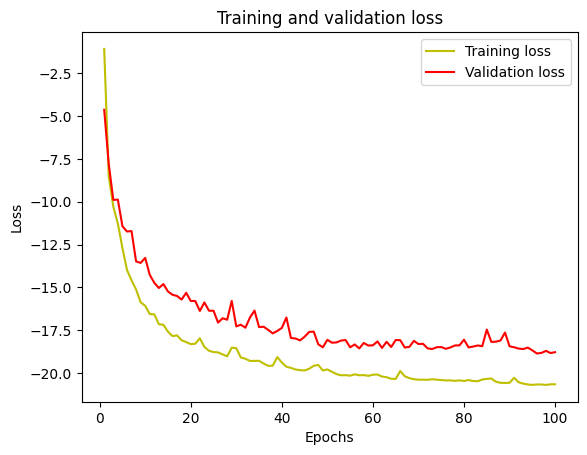

In [44]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

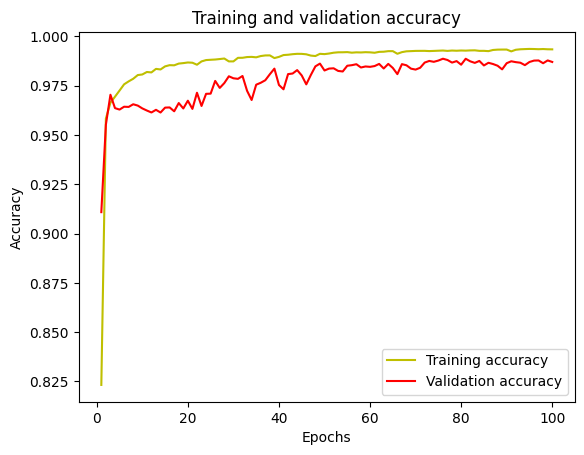

In [46]:
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()